In [1]:
################################
# Scientific imports
################################
import gc
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from astropy.io import fits
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange

################################
# SciKitLearn Imports
################################
import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
#from sklearn.decomposition import RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import SpectralClustering

from IPython.display import display

################################
# MatPlotLib Settings
################################
#plt.rcParams["figure.figsize"] = (20,9)
sb.set()

In [2]:
################################
# Functions
################################
def GetLC(rndFile=-1, fullOutput=False):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    #print("Curve = {}".format(rndFile))
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.
        obj       = hdulist[0].header['OBJECT']
        #sector    = hdulist[0].header['SECTOR']

        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds     = hdulist[1].data['TIME']
        #sap_fluxes    = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # X- and Y- labels
    ylab = "PDCSAP Flux (e-/s)"
    xlab = "Time (TBJD)"

    if (fullOutput == True):
        return (tess_bjds, pdcsap_fluxes, str(rndFile), str(obj), ylab, xlab)
    else:
        return (tess_bjds, pdcsap_fluxes)

    
    
def DrawLC(n=-1, trimends=True):
    x,y,f,o,ylab,xlab = GetLC(n, fullOutput=True)

    fig, ax = plt.subplots()
    
    if (trimends):
        # Trims off the preceeding and proceeding zeroes present in the test data
        x = x[1:-1]
        y = y[1:-1]
        
    ax.plot(x,y)

    fig.suptitle("File № {} - {}".format(f, o), fontsize=20) # + str(obj) + " - Sector " + str(sector))

    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    
    
    
def FTTMyData(x,y):
    """
    Function that takes in a timeseries and then outputs a Fourier Transformed version of it
    """
    
    # First, change all 0s to NANs
    #ynew = [idx for idx, element in enumerate(y) if element == 0]
    #y[y==0] = np.nan
    
    # Is this required?
    TMP = np.correlate(y-np.mean(y),y-np.mean(y),mode='full')
    
    # FOURIER TRANSFORM THAT Y (remember to use np.nanmean instead of np.mean)
    FTY = np.fft.fft(y-np.mean(y))
    powSpectrum = np.abs(FTY)
    
    # Get Delta D
    delta_d = np.nanmean(np.diff(x))
    #print(delta_d)
    
    # DO THE THING
    F=np.fft.fftfreq(len(y),delta_d)
    #plt.plot(F,powSpectrum)
    return(F,powSpectrum)



def ConfusionMatrix(mat,textonly=False):
    
    print("> CM-START")
    
    # CHECK IF SQUARE
    if (all (len (row) == len (mat) for row in mat)):
        TN = mat[0][0]
        FP = mat[0][1]
        FN = mat[1][0]
        TP = mat[1][1]

        TPR = TP/(TP+FN)
        FPR = FP/(FP+TN)
        
        outputtext='''
        True Positives:  {}
        False Positives: {}
        True Negatives:  {}
        False Negatives: {}
        
        True Positive Rate:  {}
        False Positive Rate: {}
        '''.format(TP,FP,TN,FN,TPR,FPR)
        
        print("> CM-OUTPUT")
        
        if (textonly==False):
            return (outputtext,TPR,FPR)
        else:
            return(TP,FP,TN,FN)



def GetPositiveRates(dataArr, checkArr, param_grid): #, ncomp=8):
    
    # Make a PCA Pipeline
    print("> GPR-START")
    
    model = SVC(kernel='rbf', class_weight='balanced')
    
    # Sort data into Test and Train
    Xtrain, Xtest, ytrain, ytest = train_test_split(dataArr, checkArr, random_state=42)
    
    # Do gridsearch for svc params
    print("> GPR-GRIDSEARCH")
    grid = GridSearchCV(model, param_grid)
    
    # Fit model
    print("> GPR-FIT")
    grid.fit(Xtrain, ytrain)
    
    # Use svc params and predict
    print("> GPR-PREDICT")   
    model = grid.best_estimator_
    yfit = model.predict(Xtest)
    
    # Now that model has done, time for confusion matrix shenanigans
    print("> GPR-CONFUSION")
    mat = confusion_matrix(ytest, yfit)
    
    return (mat)



def PlotConfusionMatrix(mat):
    
    TP, FP, TN, FN = ConfusionMatrix(mat, True)
    stats = "TP:{}\nFP:{}\nTN:{}\nFN:{}".format(TP,FP,TN,FN)
    return (stats)

In [2]:
# Set up nth record
nth = 10

# Load Data
fluxArrFull = np.load("fluxlist.npy")
fluxArr = fluxArrFull[::nth]
isplanetArrFull = [1 if x==True else 0 for x in np.load("isplanetlist.npy")]
isplanetArr = isplanetArrFull[::nth]

del fluxArrFull
del isplanetArrFull

# Remove NaNs
for ts in fluxArr:
    ts = [0 if math.isnan(x) else x for x in ts]

# Garbage Collection
gc.collect()

39

In [3]:
# Check if NaN exists at all
print(np.any(np.isnan(fluxArr)))
print(np.any(np.isnan(isplanetArr)))

False
False


In [8]:
pca = PCA().fit(fluxArr)

In [23]:
plt.rcParams["figure.figsize"] = (6,4)

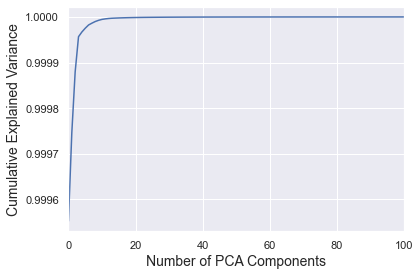

In [31]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of PCA Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14);
plt.xlim([0,100])

plt.tight_layout()
plt.savefig('imgs/pca-1.png')

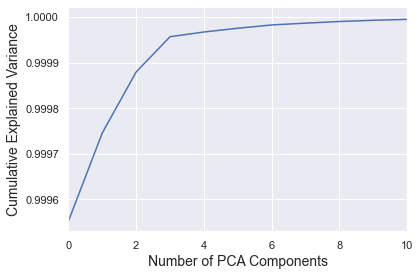

In [32]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of PCA Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14);
plt.xlim([0,10])

plt.tight_layout()
plt.savefig('imgs/pca-2.png')

In [6]:
pca = PCA(n_components=10, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

param_grid = {
    'pca__n_components': [1,2,5,10,20,50],
    'svc__C': [1, 5, 10, 50],
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]
}

search = GridSearchCV(model, param_grid, n_jobs=-1)

search.fit(fluxArr, isplanetArr)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.812):
{'pca__n_components': 1, 'svc__C': 5, 'svc__gamma': 0.0001}
